# Kvantumszámítógépek programozása - Qiskit II. rész

### Általános tudnivalók

Ezen óra célja a [Qiskit](https://qiskit.org/) python-os könyvtár megismerése különböző kvantumáramkörök segítségével.

A feladatok elvégézéshez szükséges a Python programozási nyelv ismerete, de ha valaki esetleg még nem használta, azzal sincsen semmi probléma. A feladatok megoldásához szükséges lépéseket közösen át fogjuk beszélni.

Ha valaki saját gépen szeretné elvégezni a mérést, akkor fel kell telepíteni a Python-t, a Jupyter-t és a Qiskit-et. Az utolsó kettőt `pip` segítségével a következő módon lehet telepíteni egy már működő python installációhoz: 

```
pip install notebook
pip install qiskit[visualization]
pip install qiskit-ibm-runtime
pip install qiskit-aer
```

Ezután indítsuk el a Jupyter-t a `jupyter notebook` paranccsal.

## 1. Ismétlés

### 1. Egyszerű kvantumos áramkörök a Qiskit-tel

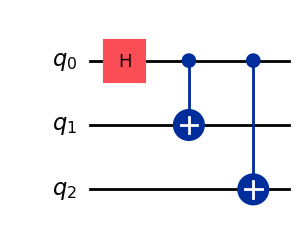

In [2]:
from qiskit import QuantumCircuit

# Egy áramkört a QuantumCircuit példányosításával tudunk létrehozni.
# A konstruktor paraméterének megadható, hogy mennyi qubit legyen az áramkörben. A qubit-ekhez indexek is tartoznak, melyek 0-tól indulnak.
qc = QuantumCircuit(3)

# Ha szeretnénk hozzáadni egy kaput az áramkörhöz, akkor azt az áramkör objektum megfelelő függvényével tudjuk megtenni.
# pl. Ha egy H kaput szeretnénk a nullás indexű qubit-re tenni, akkor azt így valósíthatjuk meg.
qc.h(0)

# Lehetőségünk van irányított kapukat is elhelyezni. Ekkor az első paraméter a kontrollbit indexe, míg a második a célbithez tartozó.
qc.cx(0,1)
qc.cx(0,2)

# Az áramkört meg is tudjuk jeleníti, ezzel ellenőrizhető, hogy azt kaptuk, amire gondoltunk.
qc.draw("mpl")

# A draw függvény paraméter egy string, amivel megadható a kimenete formátuma. Pár érdekes paraméter: "text", "latex" és "mpl" (ez az alapértelmezett).

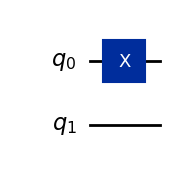

In [3]:
# Hogyan ábrázolja a Qiskit az áramköröket?
qc_x = QuantumCircuit(2,0)
qc_x.x(0)
qc_x.draw("mpl")

In [4]:
qc_x.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>,), clbits=())]

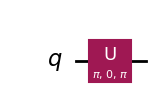

In [5]:
qc_x.data[0].operation.definition.draw('mpl')

Fontos, hogy az `CircuitInstruction` és `QuantumCircuit` különbözik, pedig mindkettő egy kvantumbit vagy kvantumbitek módosítását írja le.

#### Két áramkör összkapcsolása

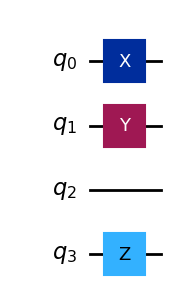

In [6]:
# Készítsünk két áramkört külön-külön, majd egyesítsük őket
qc_a = QuantumCircuit(4)
qc_a.x(0)
 
qc_b = QuantumCircuit(2, name="qc_b")
qc_b.y(0)
qc_b.z(1)
 
# A compose függvény első paramétere az áramkör, amit hozzá szeretnénk adni a megfelelő áramkörünkhöz.
# A második paraméter pedig azok a kvantumbitek, amiken hatni fog.
combined = qc_a.compose(qc_b, qubits=[1, 3])
combined.draw("mpl")

Egy másik megoldás, ha az áramkörünket instrukcióvá alakítjuk. Ezután már elég csak úgy kezelni, mint pl. egy kaput.

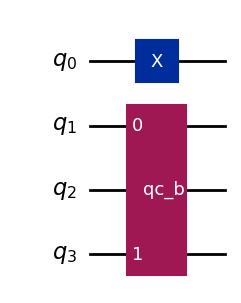

In [7]:
qc_a = QuantumCircuit(4)
qc_a.x(0)

qc_b = QuantumCircuit(2, name="qc_b")
qc_b.y(0)
qc_b.z(1)

# Az append függvénnyel a meglévő áramkörhöz tudunk új elemeket hozzáfűzni.
# Itt szintén meg kell adni, hogy mely kvantumbitekre hasson az új elem.
inst = qc_b.to_instruction()
qc_a.append(inst, [1, 3])
qc_a.draw("mpl")

Ha az áramkör, amit instrukcióként akarunk használni unitér, akkor úgy tudjuk kezelni, mint bármelyik más kaput. Például vezérelt változatot is tudunk készíteni belőle.

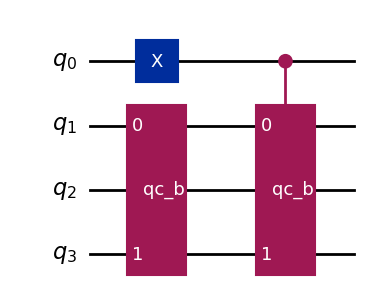

In [8]:
gate = qc_b.to_gate().control()
# Mivel ez egy vezérelt kapu, ezért 3 indexet kell megadni.
qc_a.append(gate, [0, 1, 3])
qc_a.draw("mpl")

Ha szeretnénk benézni a színfalak mögé, akkor hanszálhatjuk a `decompose` függvényt, amivel minden instrukció megvalósítását láthatjuk.

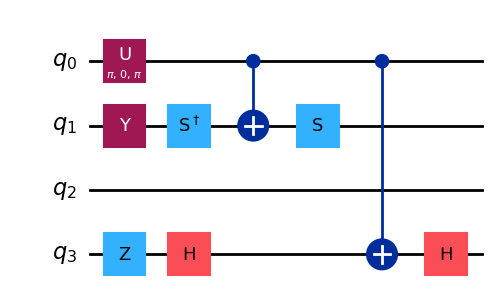

In [9]:
qc_a.decompose().draw("mpl")

#### Áramkörök parametrizálása

Sok kvantumos algoritmus működésében ugyanazt az áramkört használjuk minimális változtatásokkal. Például az állapotok forgatását a különböző futtatásokban más és más szöggel használjuk. Ezt a Qiskit-ben a `Parameter` osztállyal lehet megoldani.

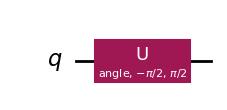

In [10]:
from qiskit.circuit import Parameter
angle = Parameter("angle")  # Létrehozások nem adunk neki értéket.
 
qc = QuantumCircuit(1)
qc.rx(angle, 0)
 
# A kezeléséhez szükgéses ez a függvény
from qiskit.transpiler import PassManagerConfig
from qiskit.transpiler.preset_passmanagers import level_3_pass_manager
qc = level_3_pass_manager(PassManagerConfig(basis_gates=['u', 'cx'])).run(qc)
 
qc.draw("mpl")

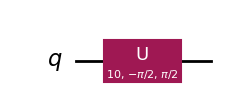

In [11]:
# A különböző változatokat pedig így tudjuk létrehozni:
circuits = []
for value in range(100):
    circuits.append(
        qc.assign_parameters({ angle: value })
    )
 
circuits[10].draw("mpl")

In [12]:
# Ha egy áramkör tartalmaz parémetereket, akkor azt könnyen le tudjuk kérni
qc.parameters

ParameterView([Parameter(angle)])

#### Előre elkészített áramkörök használata

A `qiskit.circuit.library` modulban számos előre elkészített áramkört találunk, amit a korábban megismert `compose` függvénnyel könnyen felhasználhatunk a saját áramkörünkben. Ebben a modulban speciális kapuk is elérhetőek, pl. az `MCX` kapu.

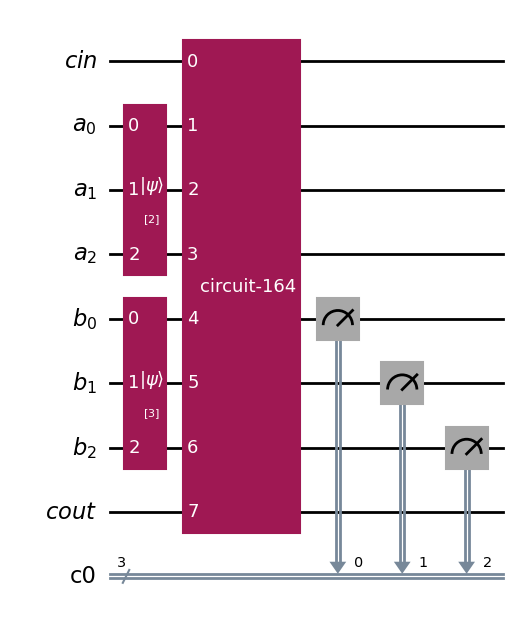

In [13]:
# Példa két 3 bites szám összeadására
from qiskit.circuit.library import CDKMRippleCarryAdder
adder = CDKMRippleCarryAdder(3)  # A 3 bites összeadó áramkör
 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
 
# A 2-es szám létrehozása
reg_a = QuantumRegister(3, 'a')
number_a = QuantumCircuit(reg_a)
number_a.initialize(2) # Az initialize függvénnyel megadott állapotba hozhajtuk a rendszer állapotát
 
# A 3-as szám létrehozása
reg_b = QuantumRegister(3, 'b')
number_b = QuantumCircuit(reg_b)
number_b.initialize(3) 
 
# Teljes áramkör összeállítása és a kimenetet tartalmazó klasszikus regiszter előkészítése
reg_result = ClassicalRegister(3)
circuit = QuantumCircuit(*adder.qregs, reg_result)
 
# Áramkörök összekapcsolása
circuit = circuit.compose(number_a, qubits=reg_a).compose(number_b, qubits=reg_b).compose(adder)
# Mérés elhelyezése
# Az első paraméter a kvantumbitek (ez lehet indexek listája is).
# A második paraméter pedig az eredmények tárolására szolgáló klasszikus bitek (ez is lehet egy indexlista)
circuit.measure(reg_b, reg_result)
circuit.draw('mpl')

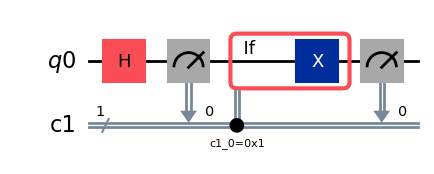

In [14]:
from qiskit.circuit import QuantumRegister, ClassicalRegister

# Figyeljük meg, hogy így is létrehozható egy áramkör
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)):
    circuit.x(q0)
circuit.measure(q0, c0)
circuit.draw("mpl")

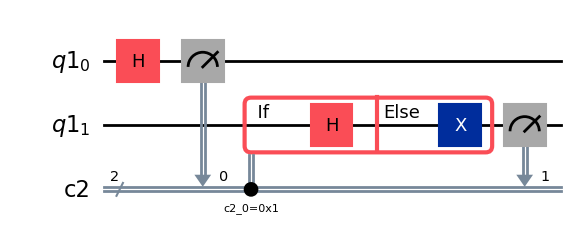

In [15]:
# De persze van if-else is
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as else_:
    circuit.h(q1)
with else_:
    circuit.x(q1)
circuit.measure(q1, c1)
 
circuit.draw("mpl")

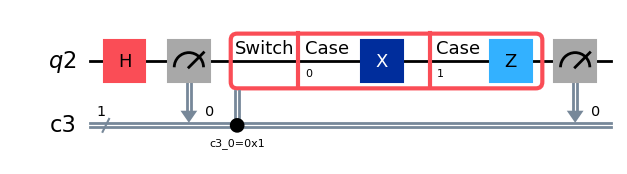

In [16]:
# Vagy a jól ismert switch-case
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.switch(c0) as case:
    with case(0):
        circuit.x(q0)
    with case(1):
        circuit.z(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")

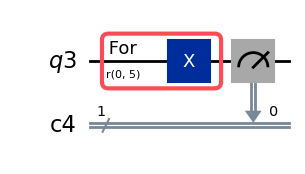

In [17]:
# Ciklusokból pedig a for és while használható. Csak a for-ra nézzük egy példát
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
with circuit.for_loop(range(5)) as _:
    circuit.x(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")

#### Áramkör futtatása és az eredmény feldolgozás, vizualizálása

In [18]:
# Miután létrehoztuk az áramkört, természetesen szeretnénk használni is. Ebben segítenek a backend-ek, melyek végrehajtják az áramkört.
# Több backend is létezik. Van, amelyik egy ideális, hibamentes kvantumszámítógépet valósít meg, de van olyan is, melyben megtalálható egy zajmodell.
# A legtöbb backend-et az Aer.get_backend() hívással tudjuk elérni paraméterként megadva a backend nevét.
from qiskit_aer import Aer

In [19]:
# A legegyszerűbb ilyen backend a statevector_simulator, mellyel a kvantumos állapotvektort tudjuk nyomonkövetni a végrehajtás során. Azaz itt "nem jön létre" klasszikus adat.
backend = Aer.get_backend("statevector_simulator")

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)

# Egy áramkör futtatása minden backend-nél azonos folyamot. Létrehozunk egy job objektumot, mely magát a szimulációt tartalmazza. Ezt a backend run függvényével tehetjük meg.
# Ez egy aszinkron folyamat, azaz a háttérben elindul és nem blokkolja a főszálat. Az eredményt a result függvénnyel tudjuk lékérni, ami viszont blokkoló hívás.
job = backend.run(qc)
result = job.result() # Blokkoló hívás!

# A statevector_simulator eredményét a result.get_statevector függvénnyel tudjuk kinyerni megadva az áramkört paraméterként.
outputstate = result.get_statevector(qc)
print(outputstate)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


In [20]:
# Az állapotvektor kiírására több lehetőség is adott.
from qiskit.visualization import array_to_latex, plot_bloch_multivector

array_to_latex(outputstate) # Latex-es kiírás

<IPython.core.display.Latex object>

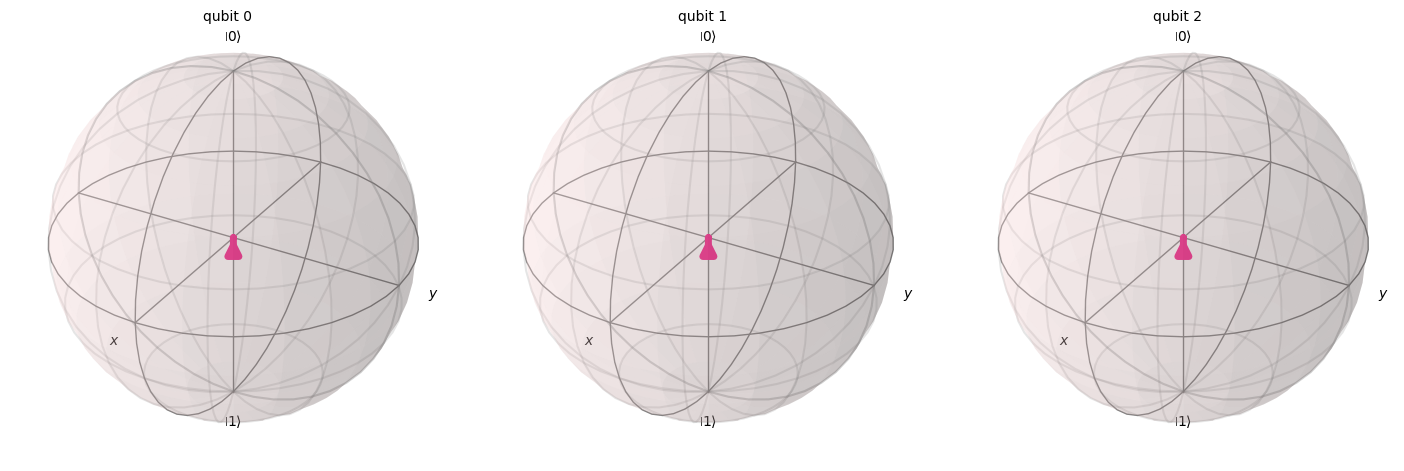

In [21]:
plot_bloch_multivector(outputstate)

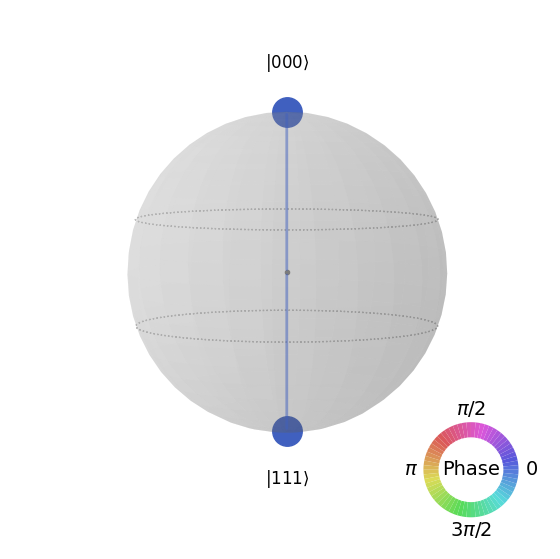

In [22]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(outputstate)

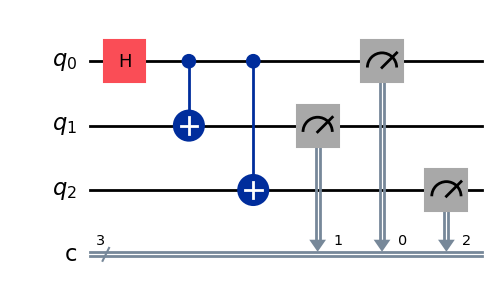

In [25]:
# A legtöbb esetben természetesen úgy szeretnénk szimulálni az áramkört, hogy a végén klasszikus információt kapjunk.
# Ebben segít többek között a qasm_simulator és az aer_simulator backend.

# A klasszikus információhoz viszont elengedhetetlen a mérés elhelyezése. Ahhoz, hogy el tudjuk tárolni a klasszikus információt, klasszikus regiszterre van szükség.
# Hozzuk létre újra az áramkört, de most adjunk hozzá 3 klasszikus bitet, melyek a 3 qubit mérési eredményeit fogják felvenni.
# A második paraméter a klasszikus bitek száma.
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)

# A measure függvény szolgál a mérések elhelyezésére, melynek első paraméter a mérni kívánt qubitek listája, a második a mérési eredményeket tároló klasszikus bitek listája.
qc.measure(range(3), range(3))
qc.draw("mpl")

In [26]:
# Próbáljuk ki az aer_simulator-t
backend = Aer.get_backend("aer_simulator")
# Szimuláció esetén megadható, hogy egy job-ban hányszor fusson az áramkört. Erre szolgál a shots paraméter.
result = backend.run(qc, shots=1000).result()

# A mérési eredményeket a result.get_counts függvénnyel tudjuk elérni.
counts = result.get_counts()
print(counts)

{'111': 481, '000': 519}


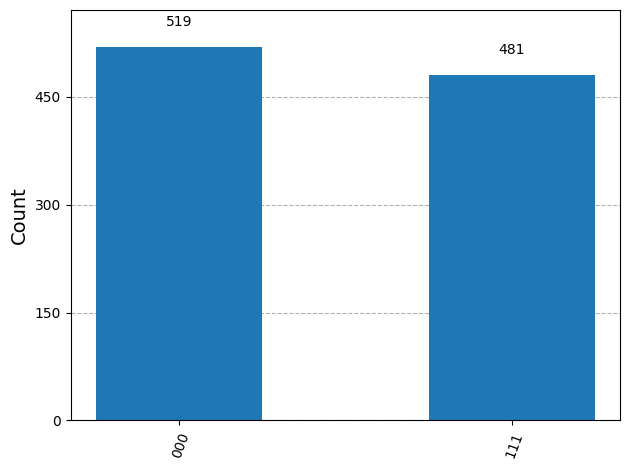

In [27]:
# A mérési eredményeket jobban is tudjuk szemlélteni.
from qiskit.visualization import plot_histogram

plot_histogram(counts)

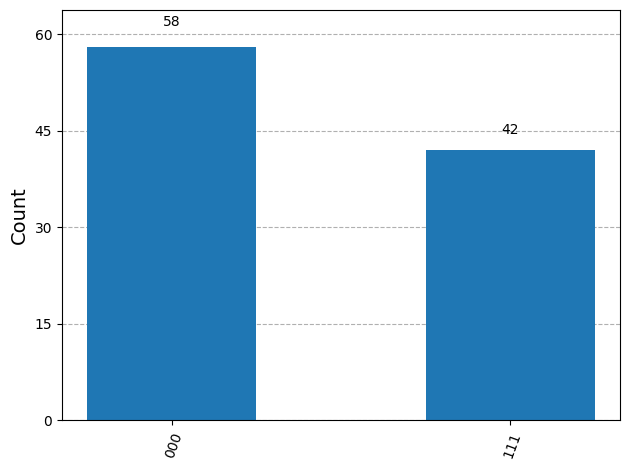

In [28]:
# A másik sokszor használt backend a qasm_simulator.
# Használatakor viszont nem lehet egyszerűen odadni az áramkört, hanem át kell alakítani, hogy a qasm_simulator által is értelmezhető formátumba kerüljün.
# Ebben segít a transpile függvény.
from qiskit import transpile

backend = Aer.get_backend("qasm_simulator")
counts = backend.run(transpile(qc, backend), shots=100).result().get_counts()

plot_histogram(counts)

A futtatáshoz használhatjuk az IBM valódi kvantumszámítógépeinek modelljét.

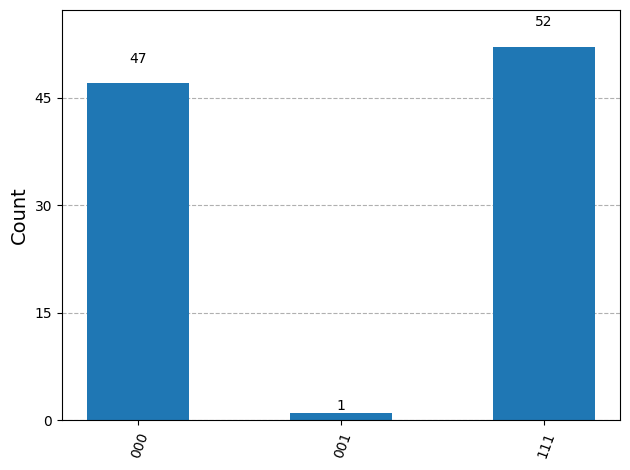

In [30]:
from qiskit_ibm_runtime.fake_provider import FakeAuckland

backend = FakeAuckland()

counts = backend.run(transpile(qc, backend), shots=100).result().get_counts()

plot_histogram(counts)

#### Tetszőleges állapot megadása

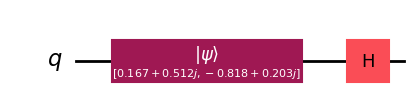

In [31]:
from qiskit.quantum_info import random_statevector

state = random_statevector(2)

qc = QuantumCircuit(1)

qc.initialize(state, 0)
qc.h(0)
qc.draw('mpl')

### Áramkör futtatása valódi kvantumszámítógépén

**FONTOS: Ez csak az IBM token-nel működik.**
```python
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler
shots = 1024

# Token elmentése, ezt elég egyszer meghívni. Vigyázat: Ez a függvény sima szövegéként menti el a token-t. Nem titkosítva!
service = QiskitRuntimeService.save_account(token="<YOUR_API_KEY>") # Opcionálisan megadható az IBM Cloud instance neve, a használt előfizetői modell és még sok más paraméter.
# Ezután bárhol és bármikor be lehet tölteni a következő függvénnyel:
sevice = QiskitRuntimService()
# Lekérjük a legkevésbé használt számítógépet.
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
print(backend.name)
# Lefuttatjuk az áramkört.
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
t_qc = transpile(qc, backend, optimization_level=3)
sampler = Sampler(backend=backend)
job = sampler.run([t_qc], shots=1000)
```

Ezután a `job` objektum úgyanúgy használható, mint a korábbi szimulációs változatnál. Az állapotnák követésére használhatunk beépített függvényeket.

**FONTOS: Ez a futtatás sokkal hosszabb ideig is tarthat mint a szimuláció. A `result()` hívás így sokáig blokkolhat!**

## 2. Egyszerű áramkörök elkészítése

Készítsük el a következő áramkört és végezzünk rajta szimulációt 1000 alkalommal.

![Egy szimpla H kapu](h_gate_simple.png)

## 3. Szupersűrű kódolás és teleportáció

### Összefonódás és Bell-állapotok

Rövid összefoglaló a Bell-állapotok létrehozásáról:

![A Bell-állapotok előállítása](bell_states.png)

Készítsük el a fenti áramkört felhasználva az óra elején megismert `initialize` függvényt!

Szimuláljuk a működését!

### Szupersűrű kódolás

Alice szeretne átküldeni két klasszikus bit által leírt információt Bob-nak. Klasszikusan ehhez 2 bitre van szüksége, ami maga az adat.

Kvantumosan ez megoldható kihasználva az összefonódást. A protokoll működéséhez szükségünk van egy megbízható harmadik félre Charlie-ra, aki ellátja Alice-t és Bob-ot egy összefonódott párral. A teljes folyamat leírása a következő:

![A szupersűrű kódolás](superdense.jpg)

Forrás: [IBM](https://learn.qiskit.org/content/v2/ch-algorithms/images/superdense.jpg)

Charlie kiindulási állapota a $|00\rangle$. Ezután a $H$ majd $CNOT$ kapukat használva előállítja az egyik Bell-állapotot: $$\frac{1}{\sqrt{2}}(\|00\rangle + |11\rangle)\$$

A "felső" qubit Alice-hoz kerül, míg az "alsó" Bob-hoz. Ezután Alice az elküldendő klasszikus információ alapján végrehajta a következő kapukat:

![Alice által használt kapuk és az eredmények](alice_operations_and_results.jpg)

Forrás: [IBM](https://learn.qiskit.org/course/ch-algorithms/superdense-coding)

Bob ezután megkapja Alice qubit-jét és végrehajta a Charlie által végzett kapukat fordított sorrendben és a következőket állapotokat kapja:

![Bob által használt kapuk eredménye](bob_operations_and_results.jpg)

Forrás: [IBM](https://learn.qiskit.org/course/ch-algorithms/superdense-coding)

Készítsük el a szupersűrű kódolást megvalósító áramkört! Az elküldendő adat legyen megadható paraméterként.

In [28]:
def encode_message(circuit, qubit, msg):
    pass

Futtassuk az áramkört egy tetszőleges kétbites információval!

Sikeresen megkapta Bob az adatot?

**FONTOS**: A qiskit-ben a klasszikus regiszterekben található bitértékek fordított sorrendben jelennek meg. Emiatt például a `10` string küldése során a mérésnél `01` látszik és fordítva.

### Teleportáció

Alice szeretné elküldeni egy kvantumállapotot Bob-nak. Hogyan tudná ezt megtenni?

A kvantum teleportáció segítségével Alice képes elküldeni akár egy ismeretlen kvantumállapotot Bob-nak, de az "eredeti" állapot megsemmisül a folyamat során.

![Teleportáció rövid összefoglalása](teleport_ibm.jpg)

Forrás: [IBM](https://learn.qiskit.org/content/v2/ch-algorithms/images/tele1.jpg)

A megoldás felhasználja az összefonódás jelenségét. Az áramkör felépítése pedig a következő:

![A teleportáció áramköre](teleportation.jpg)

Forrás: [IBM](https://learn.qiskit.org/course/ch-algorithms/quantum-teleportation)

Készítsük el az áramkört egy tetszőleges kiindulási állapottal a $q_0$ qubit-re!

Használjuk fel a korábban elkészített Bell-párokat előállító áramkört és a következő segítséget:

```python
# Akkor használjuk az X és Z kaput, ha a crx és a crz klasszikus regiszterekben 1-es található.
qc.x(qubit).c_if(crx, 1)
qc.z(qubit).c_if(crz, 1)
```

Szimuláljuk az áramkört! Megkapta Bob a kiindulási állapotot?

## 4. Quantum Random Access Code - QRAC

Láthattuk, hogy egy qubit 2 értéket is felvehet egyszerre. Ez $n$ qubit esetén $2^n$, így úgy tűnik, hogy sokkal több információt tudunk átküldeni valakinek qubiteket használva. Ez nem teljesen van így. Belátható, hogy ha nem használjuk a megismert szupersűrű kódolást (és az összenfonódást), akkor egy $n$ bites klasszikus információt csak egy $n$ qubit-es rendszerrel tudunk megbízhatóan átküldeni. Mi történik akkor, ha kicsit "könnyítünk" a feladaton?

Tegyük fel, hogy Alice szeretne elküldeni $n$ bitet Bob-nak qubit-ekbe kódolva. Bob viszont ezen $n$ közül véletlenül csak egyet szeretne kiolvasni. Alice nem tudja, hogy melyiket, ezért úgy szeretné kódolni őket, hogy bármelyiket is választja Bob, $0.5$-nél nagyobb legyen annak a válószínűsége, hogy a jó értéket kapja.

Klasszikusan ezt nem tudjuk megoldani, hiszen ha csak 1 bitet küldhetünk, akkor Bob csupán az esetek felében fogja kiolvasni a helyes eredményt. Ennek a feladatnak a megoldásában segít a Quantum Random Access Code (vagy QRAC). A QRAC kódókat a következő három paraméterrel lehet megadni: $(n, m, p)$, ahol $n$ a kódolandó klasszikus információ, $m$ a felhasznált qubit-ek száma, míg $p$ az a valószínűség, mellyel Bob a helyes eredményt kapja bármely bitpozíció választásakor.

### A $QRAC(2, 1, 0.85)$ kód

Először koncentráljuk csak az első bitre és legyen az adat `10` vagy `00`. Ismerve a $p$ paramétert melyik állapotokat használhatjuk?

A $p$ paraméterből kiindulva annak a valószínűsége, hogy a `10` kódolása után `1`-et mérünk $0.85$. Ezt azt jelenti, hogy egy olyan kvantumállapotba kell kódolni, amire ez teljesül. Azaz a $|1\rangle$-hez tartozó valószínűségi amplitúdóra igaz, hogy az abszolútértékének négyzete $0.85$. A `00` kódolásánal is úgyanígy járunk el, de itt a $|0\rangle$-hoz tartozó amplítúdóról tudjuk ugyanezt elmondani. A két állapot tehát a következő:

A `10`-hoz a $\sqrt{1-0.85}|0\rangle + \sqrt{0.85}|1\rangle$, míg a `00`-hoz a $\sqrt{0.85}|0\rangle + \sqrt{1-0.85}|1\rangle$ lesz rendelve, melyek vektorként ábrázolva a következők:

![Egy bit](qrac_2_elso_bit.png)

Lehet-e ezen alakítani, hogy kicsit könnyebben legyen kezelhető?

Igen, ezeket az állapotok a következő alakban is megadhatjuk:

A `00`-hoz a $\cos(\frac{\pi}{8})|0\rangle + \sin(\frac{\pi}{8})|1\rangle$, míg az `10`-hoz a $\cos(\frac{3\pi}{8})|0\rangle + \sin(\frac{3\pi}{8})|1\rangle$. Így is teljesül a kívánt $p$ paraméter.

Most térjünk át a többi lehetőségre. Hogyan tudjuk elérni, hogy itt is teljesüljön $p$, ha az előző két állapot már "foglalt"?

Használjuk ki a $|+\rangle$, $|-\rangle$ bázisokat, méghozzá úgy, hogy tükrözzük az előbbi két állapotot a függőleges tengelyre.

A kész kód tehát a következő:

![QRAC 2 állapotok](qrac_2_states_and_bases.png)

Forrás: [M Hayashi et al 2006 New J. Phys. 8 129](https://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta)

![QRAC 2 kódolás](qrac_2_kodolas.png)

A választott bittől függően Bob pedig a következőt fogja tenni:

Ha az első bitet szeretné kiolvasni akkor a ${|0\rangle, |1\rangle}$ bázist, ha a második bitet szeretné kiolvasni, akkor ${|+\rangle, |-\rangle}$ bázist fogja használni a méréshez.

Használjuk fel az `U` kaput, melyhez a mátrix:

$\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U(\theta, \phi, \lambda) =
    \begin{pmatrix}
        \cos\left(\th\right)          & -e^{i\lambda}\sin\left(\th\right) \\
        e^{i\phi}\sin\left(\th\right) & e^{i(\phi+\lambda)}\cos\left(\th\right)
    \end{pmatrix}\end{split}\end{aligned}\end{align}$

Készítsük el a fent felvázolt kódolást egy tetszőleges két bites adatra!

Teszteljük le, hogy a $0.85$-ös $p$ paraméter tényleg teljesül!

#### Kitérő: Több áramkör közös tesztelése

In [29]:
qc_1 = QuantumCircuit(1)
qc_1.h(0)
qc_1.measure_all()
qc_2 = QuantumCircuit(1)
qc_2.x(0)
qc_2.measure_all()

backend = Aer.get_backend("aer_simulator")
# Figyeljük meg, hogy a run paraméter a két áramkör.
results = backend.run([qc_1, qc_2]).result()

A `results` tartalma ekkor a következő lesz. Vegyük észre, hogy a két áramkörhöz külön-külön megvannak az adatok.

In [30]:
results

Result(backend_name='aer_simulator', backend_version='0.15.1', qobj_id='', job_id='eb781a74-5045-4d5f-9f98-462fb8d9c980', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 526, '0x0': 498}), header=QobjExperimentHeader(creg_sizes=[['meas', 1]], global_phase=0.0, memory_slots=1, n_qubits=1, name='circuit-2776', qreg_sizes=[['q', 1]], metadata={}), status=DONE, seed_simulator=1204406983, metadata={'time_taken': 0.000490809, 'num_bind_params': 1, 'parallel_state_update': 16, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 1, 'sample_measure_time': 0.000166262, 'active_input_qubits': [0], 'num_clbits': 1, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 126103, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}, time_taken=0.000490809), ExperimentResult(

In [31]:
results.get_counts()

[{'1': 526, '0': 498}, {'1': 1024}]

Felhasználva a fenti példát, készítsük el a 4 lehetséges adat és Bob két lehetséges választása által adott áramköröket és teszteljük őket együtt!

In [ ]:
from math import pi
from qiskit import transpile

# Forrás: https://notebook.community/antoniomezzacapo/qiskit-tutorial/community/terra/qis_adv/single-qubit_quantum_random_access_coding

backend = Aer.get_backend('qasm_simulator') # the device to run on
shots = 1024

# A cos-ban található szorzók az eltárolása
rotationNumbers = {"00":1, "10":3, "11":5, "01":7}


qr = QuantumRegister(1)

cr = ClassicalRegister(1)


encodingCircuits = {}

for bits in ("00", "01", "10", "11"):
    circuitName = "Encode"+bits
    encodingCircuits[circuitName] = QuantumCircuit(qr, cr, name=circuitName)
    encodingCircuits[circuitName].u(rotationNumbers[bits]*pi/4.0, 0, 0, qr[0]) # Az U theta/2-vel forgat, ezért kell a /4.
    encodingCircuits[circuitName].barrier()


encodingCircuits["Encode01"].draw()
decodingCircuits = {}

for pos in ("First", "Second"):
    circuitName = "Decode"+pos
    decodingCircuits[circuitName] = QuantumCircuit(qr, cr, name=circuitName)
    if pos == "Second": # Ha a másodikat kell megmérni, akkor kell még egy H kapu.
        decodingCircuits[circuitName].h(qr[0])
    decodingCircuits[circuitName].measure(qr[0], cr[0])

circuitNames = []
circuits = []
for k1 in encodingCircuits.keys():
    for k2 in decodingCircuits.keys():
        circuitNames.append(k1+k2)
        copy_circ = encodingCircuits[k1].copy()
        copy_circ.append(decodingCircuits[k2], [0], [0])
        circuits.append(copy_circ)

print("List of circuit names:", circuitNames)

In [ ]:
circuits[0].draw()

Midegyik esetben teljesült a dekódolással kapcsolatos követelmény?

In [ ]:
from qiskit.visualization import plot_histogram

job = backend.run([transpile(circ, backend) for circ in circuits], shots=shots)
results = job.result()
plot_histogram(results.get_counts(), legend=circuitNames)

#### A $QRAC(3, 1, 0.79)$ kód

Mi a helyzet 3 bitnyi információ esetén? Továbbgondolva az előző konstrukciót, mit kell módosítanunk?

Használjuk ki, hogy a valószínűségi amplitúdók komplex számok, azaz helyezzük el a kódolt állapotok a Bloch-gömb felszínén.

A $QRAC(3, 1, 0.79)$ tehát a következő:

![QRAC_3_states](qrac_3_states.png)

Forrás: [M Hayashi et al 2006 New J. Phys. 8 129](https://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta)

Alice kódolása a következő:

![QRAC 3 kódolás](qrac_3_coding.png)

Ahol $\tilde{\theta} = \pi \cdot n + \frac{1}{2} \cos^{-1}\left(\frac{1}{\sqrt{3}}\right), n \in Z$

Forrás: [M Hayashi et al 2006 New J. Phys. 8 129](https://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta)

Bob, választásától függően, pedig az alábbi bázisokban fog mérni:

![QRAC 3 bázisok](qrac_3_bases.png)

Készítsük el a QRAC$(3, 1, 0.79)$ kódolást egy válaszott 3 bites adatra!

Készíthető $QRAC(n>3, 1, p>0.5)$ kódolás?

Nem. Belátható, hogy $QRAC(4, 1, p)$ kód nem hozható létre. Forrás: [M Hayashi et al 2006 New J. Phys. 8 129](https://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta)

## Bónusz feladatok

### 1. Miután megismertük a QRAC kódolást és az egy qubit-be kódolható maximális klasszikus bitek számát, készítsünk egy QRAC kódot (6, 2, p) paraméterrel!

### 2. Készítsük el a BB84 QKD protokoll egyszerűsített változatát felhasználva a teleportációnál megismert kontrollált kapukat!